In [5]:
import torch
import cv2

In [2]:
from dep_tools.searchers import PystacSearcher
from dep_tools.loaders import OdcLoader
import src.utils as utils

from dep_tools.grids import PACIFIC_GRID_10
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
print("CUDA available:", torch.cuda.is_available())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True


In [3]:
from importlib import reload
reload(utils)

<module 'src.utils' from '/data/dep-veg/code/src/utils.py'>

In [4]:
def resize_figure(fig, factor=2):
    return fig.set_size_inches(*(fig.get_size_inches() * factor))

def imshow(im, fig=None, ax=None, alpha=1, cmap=None, label='', return_true=False, resize=False):
    '''
    im: np array [c,h,w], value range from 0 to 255
    '''
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if torch.is_tensor(im):
        im = im.detach().cpu().numpy()
    
    # if im.max() <= 1:
    #     im = im * 255

    im = im.astype(np.uint8)
    if im.shape[0] == 3: #if is an RGB image, not a mask
        if ax is None:
            fig, ax = plt.subplots(1,1)
        ax.imshow(im.transpose([1,2,0]))
    else: #if a mask
        if len(im.shape) == 2:
            im = im[None]
        if ax is None:
            fig, ax = plt.subplots(1,len(im))
        if len(im) == 1:
            f = ax.imshow(im[0], alpha=alpha, cmap=cmap)
            divider = make_axes_locatable(ax)
            # if 1 in im.shape: # add a colorbar
            cax = divider.append_axes('right', size='7%', pad=0.05)
            fig.colorbar(f, cax=cax, ax=ax)
            fig.tight_layout()
            ax.set_title(label)
        else:
            for i in range(im.shape[0]):
                f = ax[i].imshow(im[i], alpha=alpha, cmap=cmap)
                ax[i].axis('off')
                divider = make_axes_locatable(ax[i])
                # if 1 in im.shape: # add a colorbar
                cax = divider.append_axes('right', size='7%', pad=0.05)
                fig.colorbar(f, cax=cax, ax=ax[i])
                fig.tight_layout()
                ax[i].set_title(label+' '+ str(i))

    if resize:
        resize_figure(fig, resize)
    if return_true:
        return fig, ax

In [5]:
catalog = "https://stac.digitalearthpacific.org"
collection = "dep_s2_geomad"

# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
tile_id = (64, 20)  # Suva

geobox = PACIFIC_GRID_10.tile_geobox(tile_id)
datetime = "2024"#"2025-01"

# model = joblib.load("models/2025_04_17_rf.joblib")

searcher = PystacSearcher(
    catalog=catalog,
    collections=[collection],
    datetime=datetime,
)

loader = OdcLoader(
    bands=["red", "green", "blue"],
    chunks={"x": 1024, "y": 1024},
    # groupby="solar_day",
    # fail_on_error=False,
)

In [36]:
items = searcher.search(geobox)

print(f"Found {len(items)} items")

Found 6 items


In [7]:
data = loader.load(items, geobox)

data

<xarray.Dataset> Size: 553MB
Dimensions:      (y: 9600, x: 9600, time: 1)
Coordinates:
  * y            (y) float64 77kB -1.984e+06 -1.984e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 77kB 3.144e+06 3.144e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    red          (time, y, x) uint16 184MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 184MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 184MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [19]:
data.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01

In [37]:
reload(utils)

<module 'src.utils' from '/data/dep-veg/code/src/utils.py'>

In [38]:
processor = utils.VegProcessor()


Loaded referenced mean: [[[82.4415166 ]]

 [[96.35663436]]

 [[76.91169149]]]
Loaded referenced std: [[[31.70003895]]

 [[26.98854819]]

 [[21.7643902 ]]]


In [39]:
height = processor.process(data)
height

Preprocess input...
Fourth channel detected, which has min = 1, max=1. It will be treated as alpha channel
Step 1

Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 13201.16it/s]


1369 patches remaining.

Finish initiation. Start inferencing...


  0%|          | 0/229 [00:00<?, ?it/s]

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/lightning/fabric/wrappers/___torch_mangle_3040.py", line 11, in forward
    input: Tensor) -> Tensor:
    _forward_module = self._forward_module
    return (_forward_module).forward(input, )
            ~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
  File "code/__torch__/seg_model/___torch_mangle_2529.py", line 14, in forward
    decoder = self.decoder
    encoder = self.encoder
    _0, _1, _2, _3, = (encoder).forward(input, )
                       ~~~~~~~~~~~~~~~~ <--- HERE
    _4 = (segmentation_head).forward((decoder).forward(_0, _1, _2, _3, ), )
    return _4
  File "code/__torch__/timm/models/_features/___torch_mangle_2472.py", line 20, in forward
    stem_1 = self.stem_1
    stem_0 = self.stem_0
    _0 = (stem_1).forward((stem_0).forward(input, ), )
                           ~~~~~~~~~~~~~~~ <--- HERE
    _1 = (stages_0).forward(_0, )
    _2 = (stages_1).forward(_1, )
  File "code/__torch__/torch/nn/modules/conv/___torch_mangle_2020.py", line 12, in forward
    bias = self.bias
    weight = self.weight
    x = torch._convolution(input, weight, bias, [4, 4], [0, 0], [1, 1], False, [0, 0], 1, False, False, True, True)
        ~~~~~~~~~~~~~~~~~~ <--- HERE
    return x

Traceback of TorchScript, original code (most recent call last):
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/conv.py(456): _conv_forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/conv.py(460): forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1508): _slow_forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1527): _call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1518): _wrapped_call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/timm/models/_features.py(235): _collect
/home/thong/.venv/seg/lib/python3.10/site-packages/timm/models/_features.py(281): forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1508): _slow_forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1527): _call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1518): _wrapped_call_impl
/home/thong/segmentation-linux/seg_model.py(177): forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1508): _slow_forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1527): _call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1518): _wrapped_call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/lightning/fabric/wrappers.py(121): forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1508): _slow_forward
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1527): _call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/nn/modules/module.py(1518): _wrapped_call_impl
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/jit/_trace.py(1065): trace_module
/home/thong/.venv/seg/lib/python3.10/site-packages/torch/jit/_trace.py(798): trace
/home/thong/segmentation-linux/trace_model.py(74): <module>
RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor


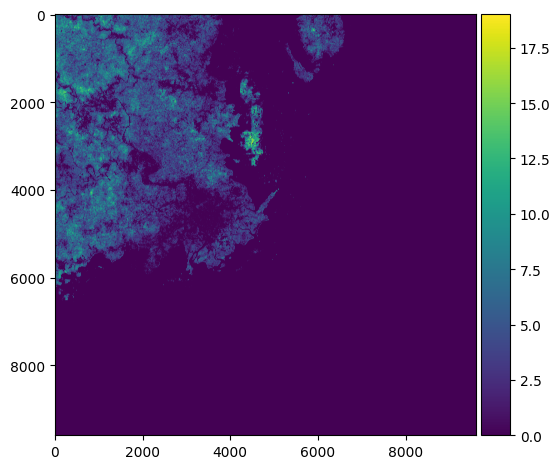

In [35]:
imshow(height['height'].data)

In [9]:
im = data.to_array().squeeze().values # took 46s

In [41]:
import copy
im_ = copy.deepcopy(im)
# im_ = im_[:, :2000, :2000]

In [39]:
im_ = processor.preprocess(im_)

((3, 2000, 2000), None)

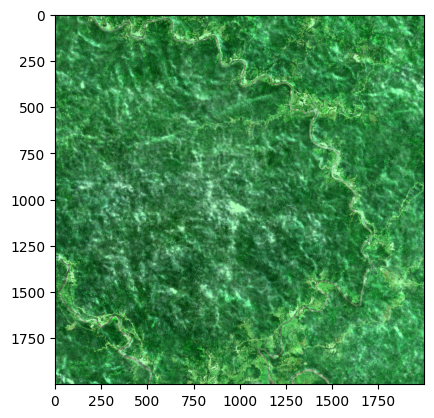

In [13]:
im_.shape, imshow(im_)

In [23]:
processor.mask.astype('bool').dtype == 'bool'

True

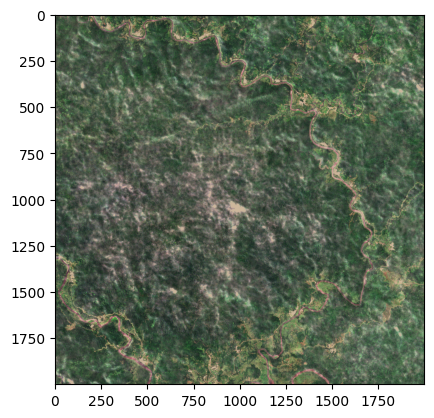

In [40]:
im_ = processor.standardize(im_)
imshow(im_)

In [13]:
allveg = processor.infer_veg_segmentation(im_, standardize=False)
allveg.shape


Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 13242.69it/s]


1369 patches remaining.

Finish initiation. Start inferencing...


100%|██████████| 229/229 [02:52<00:00,  1.33it/s]


(1, 9600, 9600)

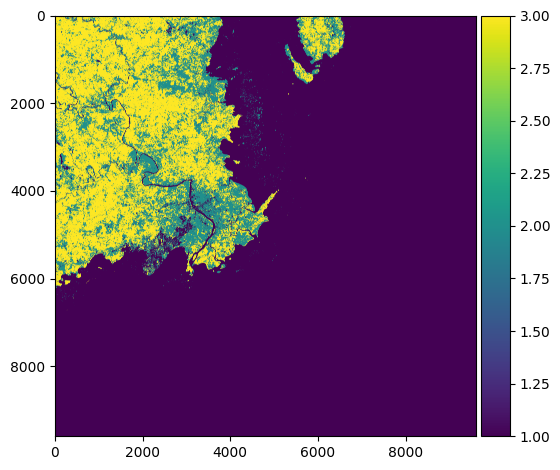

In [14]:
imshow(allveg)

In [15]:
nonvegmask = allveg <= 1
nonvegmask = np.repeat(nonvegmask, 3, axis=0)
im_[nonvegmask] = 0

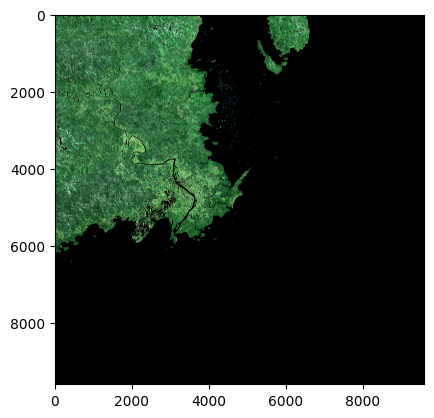

In [16]:
imshow(im_)

In [17]:
processor.mask = np.bitwise_and(processor.mask, ~nonvegmask[0])

In [12]:
height = processor.infer_height_estimation(im_, False)


Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 12267.32it/s]


1369 patches remaining.

start height inference
Finish initiation. Start inferencing...


100%|██████████| 229/229 [02:48<00:00,  1.36it/s]


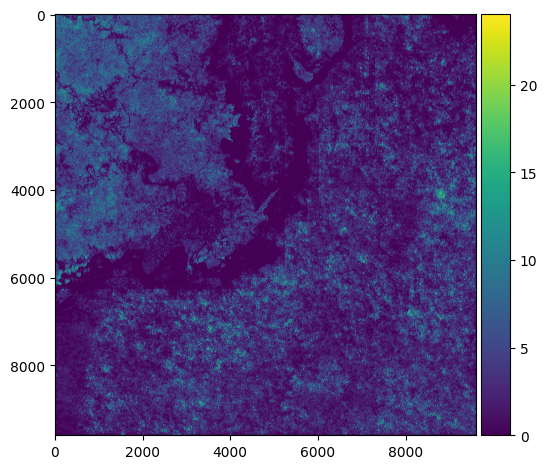

In [13]:
imshow(height)

In [42]:
height = processor.process(im_)

Preprocess input...
Step 1

Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 14146.07it/s]


1369 patches remaining.

Finish initiation. Start inferencing...


100%|██████████| 229/229 [04:25<00:00,  1.16s/it]


Step 2
step 3
standardize
patchify

Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 13794.40it/s]


1369 patches remaining.

start height inference
Finish initiation. Start inferencing...


100%|██████████| 229/229 [04:12<00:00,  1.10s/it]


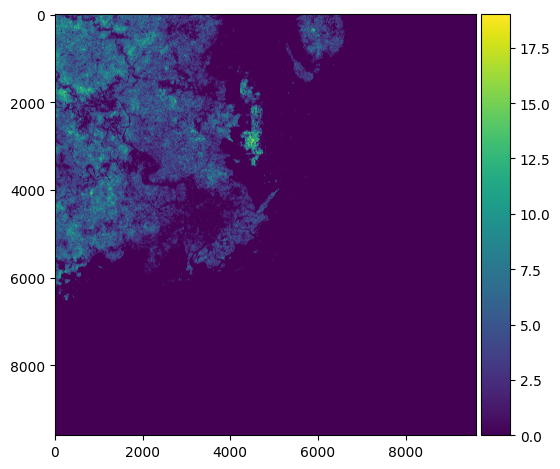

In [43]:
imshow(height)

+1 to zero valid pixels...


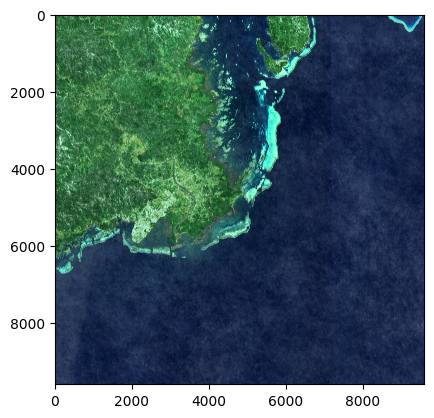

In [36]:
# data = data_np # shape [3,9600,9600]
# calculate alpha mask
if data.shape[0] == 3:
    mask = ~get_mask(data)[0]
    mask = mask.astype('uint8')
    # dilate then erode the mask to leave out the valid pixels with values = (0,0,0) inside the raster
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.dilate(mask, kernel, iterations=1) 
    mask = cv2.erode(mask, kernel, iterations=1) 

elif data.shape[0] ==4:
    print(f'Fourth channel detected, which has min = {data[-1].min()}, max={data[-1].max()}. It will be treated as alpha channel')
    mask = data[3].clip(max=1).astype('uint8') 

for i in range(3):
    vmin, vmax = np.quantile(data[i], [0.001, 0.99])
    data[i] = data[i].clip(min=vmin, max=vmax)

rgb = data[:3].transpose([1,2,0]) # [h,w,3]
rgb = cv2.normalize(rgb, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
rgb = rgb.transpose([2,0,1])#[3,h,w]
final_data = np.empty((4, *data.shape[1:]), dtype=np.uint8)    

print('+1 to zero valid pixels...')
# valid_zero_pixels = np.bitwise_and(utils.get_mask(rgb)[0], mask).astype('bool') 
# print(valid_zero_pixels.sum())
rgb[rgb == 0] = 1
rgb = rgb * mask
final_data[:3] = rgb
final_data[3] = mask * 255

imshow(final_data[:3])

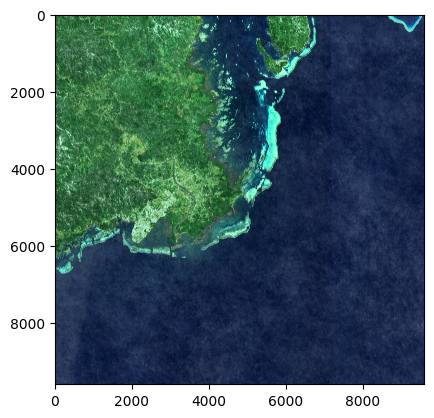

In [19]:
imshow(final_data[[0,2,1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [140..1312].


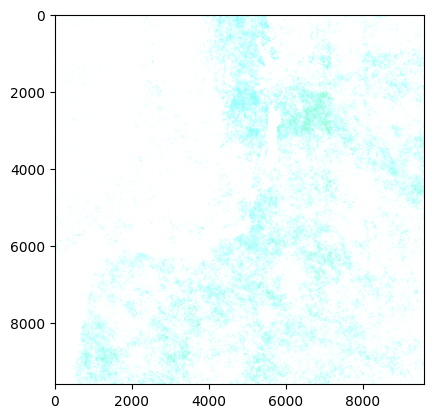

In [22]:
plt.imshow(data.transpose([1,2,0]))

In [ ]:
results = processor.process(data)

results

In [ ]:
import folium
from ipyleaflet import basemaps

masked = results.where(results.pc_deep < 0.7)  # ||  # Maybe use 0.5
masked_two = results.where(results.pc_pred > 0.1)

m = folium.Map(tiles=basemaps.Esri.WorldImagery)
m.fit_bounds(results.odc.map_bounds())

for var in results.data_vars:
    cmap = "Blues_r" if var in ("mean", "median", "depth") else "viridis"
    args = {
        "cmap": cmap,
    }
    if "pc" in var:
        args["vmin"] = 0
        args["vmax"] = 1
    results[var].odc.add_to(m, name=var, **args)

masked["mean"].odc.add_to(m, name="mean masked", cmap="Blues_r")
masked["median"].odc.add_to(m, name="median masked", cmap="Blues_r")

masked_two["mean"].odc.add_to(m, name="mean masked two", cmap="Blues_r")
masked_two["median"].odc.add_to(m, name="median masked two", cmap="Blues_r")

# Add a layer control to the map
folium.LayerControl().add_to(m)

m

In [ ]:
# results["pc_deep"].odc.write_cog("pc_deep_vanua.tif", overwrite=True)

In [ ]:
from dep_tools.namers import S3ItemPath

itempath = S3ItemPath(
    bucket="example-bucket",
    sensor="s2",
    dataset_id="sdb",
    version="9.9.9",
    time=datetime,
)